In [1]:
import os
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy.signal import butter, lfilter, freqz
from sklearn.decomposition import PCA, FastICA
from meegkit import dss
import pandas as pd
import seaborn as sns
import mne
# %matplotlib qt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
folderPath = os.path.join(os.getcwd(), 'SSVEP_BCI_Dataset')

In [4]:
matFiles = [f for f in os.listdir(folderPath) if f.endswith('.mat')]
matData = scipy.io.loadmat(os.path.join(folderPath,matFiles[1]),struct_as_record=True)

In [5]:
data = matData['data']

In [6]:
colName = ['Character', 'Frequency(Hz)', 'Phase（pi)']
characters = ['1','2','3','4','5','6','7','8','9','0','*','#']
FreqHz = [9.25,11.25,13.25,9.75,11.75,13.75,10.25,12.25,14.25,10.75,12.75,14.75]
PhasePi = [0,0,0,0.5,0.5,0.5,1,1,1,1.5,1.5,1.5]
simInfo = pd.DataFrame()
simInfo['Character'] = characters
simInfo['Frequency(Hz)'] = FreqHz
simInfo['Phase（pi)'] = PhasePi
simInfo

,Character,Frequency(Hz),Phase（pi)
0,1,9.25,0.0
1,2,11.25,0.0
2,3,13.25,0.0
3,4,9.75,0.5
4,5,11.75,0.5
5,6,13.75,0.5
6,7,10.25,1.0
7,8,12.25,1.0
8,9,14.25,1.0
9,0,10.75,1.5


In [7]:
channelInd = ['POz', 'PO3', 'PO4', 'PO5', 'PO6', 'Oz', 'O1', 'O2']

In [8]:
timeRange = np.arange(0,2.84,1/250)
len(timeRange)

710

In [9]:
electrodeIndex = 0
blockIndex = 0
targetIndex = 4
dataMat = [timeRange]
numbChannelIndex = 8
name = ['Time']+channelInd

In [10]:
for chnInd in range(numbChannelIndex):
    dataMat.append(data[chnInd,:,electrodeIndex,blockIndex,targetIndex])

In [11]:
df = pd.DataFrame(dataMat)
df = df.transpose()
df.columns = name
df = df.set_index('Time')
df.head()

,POz,PO3,PO4,PO5,PO6,Oz,O1,O2
Time,,,,,,,,
0.000,-57667.363147,-23819.403280,-27161.435912,-20358.951113,-25419.028128,-14405.474925,-26877.836995,-23620.070435
0.004,-60079.160933,-23674.742798,-28125.690110,-20050.273541,-25200.428081,-14109.582550,-26706.622643,-23369.954429
0.008,-60876.268797,-23358.242116,-27898.730510,-19750.626072,-24901.048833,-13811.902035,-26418.955709,-23070.172850
0.012,-59343.162736,-23301.558095,-26981.549083,-19847.990265,-24937.839802,-13914.943571,-26410.730267,-23137.049266
0.016,-57336.199721,-23599.953866,-26528.970988,-20231.590881,-25268.690304,-14290.855187,-26704.745096,-23493.738383


In [12]:
ndf = (df-df.mean())/df.std()
ndf.head()

,POz,PO3,PO4,PO5,PO6,Oz,O1,O2
Time,,,,,,,,
0.000,0.889370,-2.084489,0.032897,-1.971440,-2.019268,-1.910844,-2.159508,-1.982676
0.004,-0.852840,-1.405880,-1.572849,-0.693252,-1.034618,-0.654979,-1.316809,-0.911363
0.008,-1.428647,0.078838,-1.194899,0.547544,0.313888,0.608476,0.099057,0.372681
0.012,-0.321178,0.344745,0.332458,0.144373,0.148169,0.171134,0.139542,0.086231
0.016,1.128592,-1.055042,1.086124,-1.444060,-1.342095,-1.424360,-1.307568,-1.441563


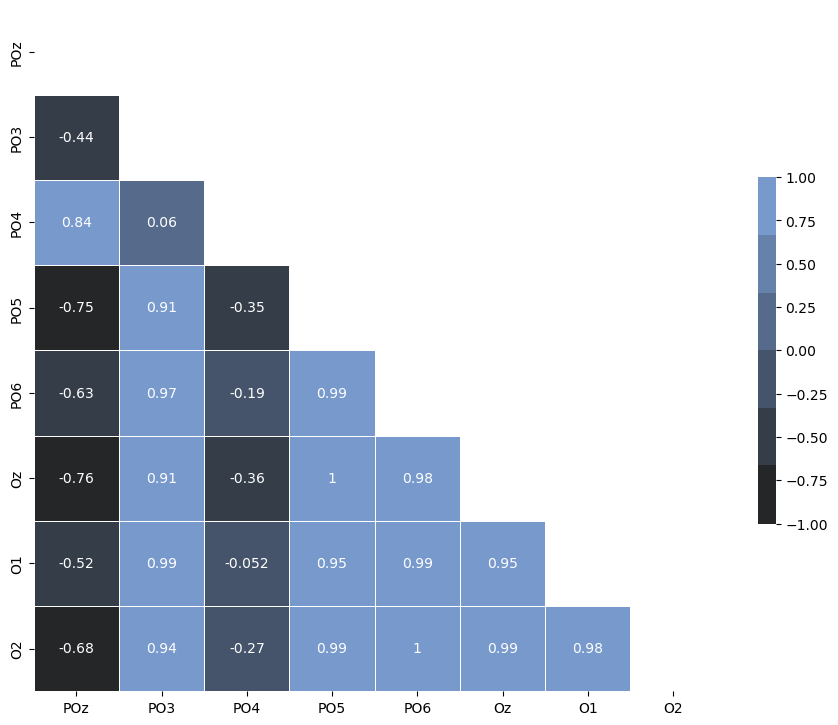

In [13]:
# Compute the correlation matrix
corr = ndf.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)
cmap = sns.dark_palette("#79C")
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
plt.show()

In [14]:
pca = PCA().fit(ndf)
explained_variance = np.cumsum(pca.explained_variance_ratio_)

Optimal number of components: 2


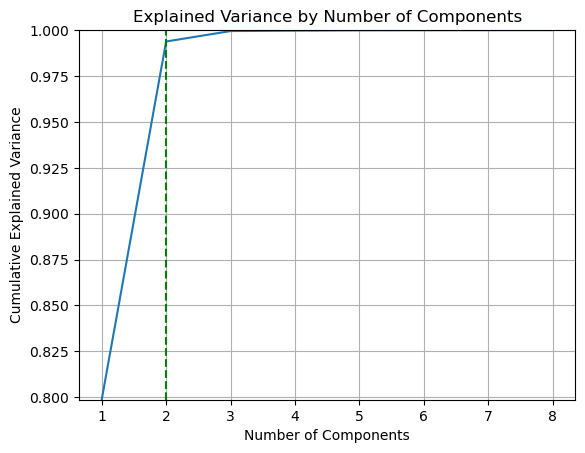

In [15]:
# Plot explained variance
plt.plot(np.arange(1, len(explained_variance) + 1), explained_variance)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by Number of Components')


# Optimal number of components (e.g., 95% variance)
n_components_optimal = np.argmax(explained_variance >= 0.95) + 1
print(f"Optimal number of components: {n_components_optimal}")
plt.vlines(x=n_components_optimal, ymin=min(explained_variance), ymax=max(explained_variance), colors='g', ls='--')
plt.ylim(min(explained_variance),max(explained_variance))
plt.grid()
plt.show()

In [16]:
n_components = n_components_optimal
transformer = FastICA(n_components=n_components,
        random_state=0,
        whiten='unit-variance')
iComp = transformer.fit_transform(ndf.values)

In [17]:
comp = ['comp1','comp2','comp3','comp4','comp5','comp6','comp7','comp8']
idf = pd.DataFrame(iComp)
idf.columns = comp[:n_components]
idf.head()

,comp1,comp2
0,1.910293,0.852085
1,1.929772,-0.914474
2,0.491796,-1.271090
3,-0.257803,0.010217
4,0.672387,1.336705


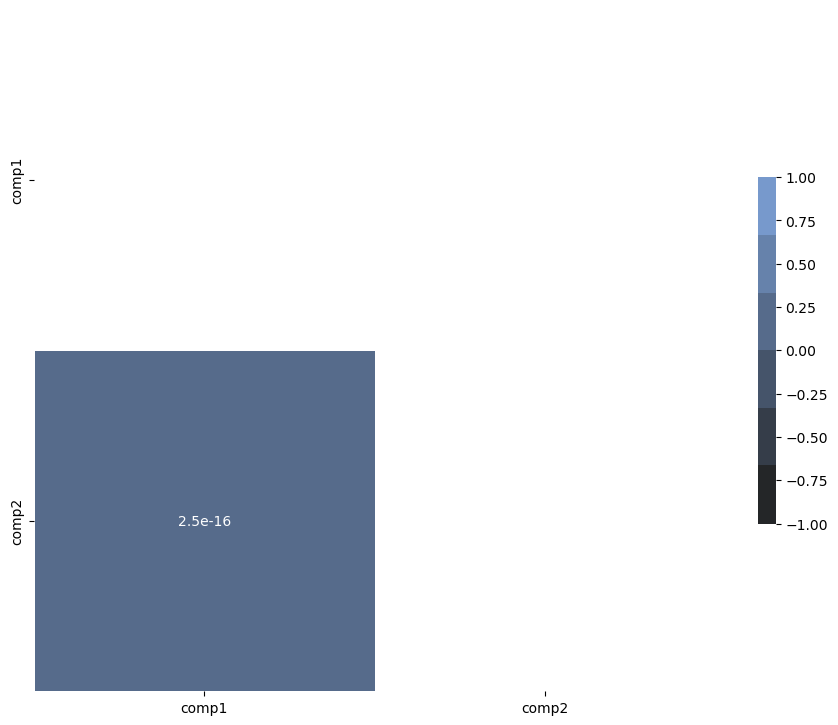

In [18]:
# Compute the correlation matrix
corr = idf.corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
# cmap = sns.diverging_palette(230, 20, as_cmap=True)
cmap = sns.dark_palette("#79C")
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1,vmin=-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot=True)
plt.show()

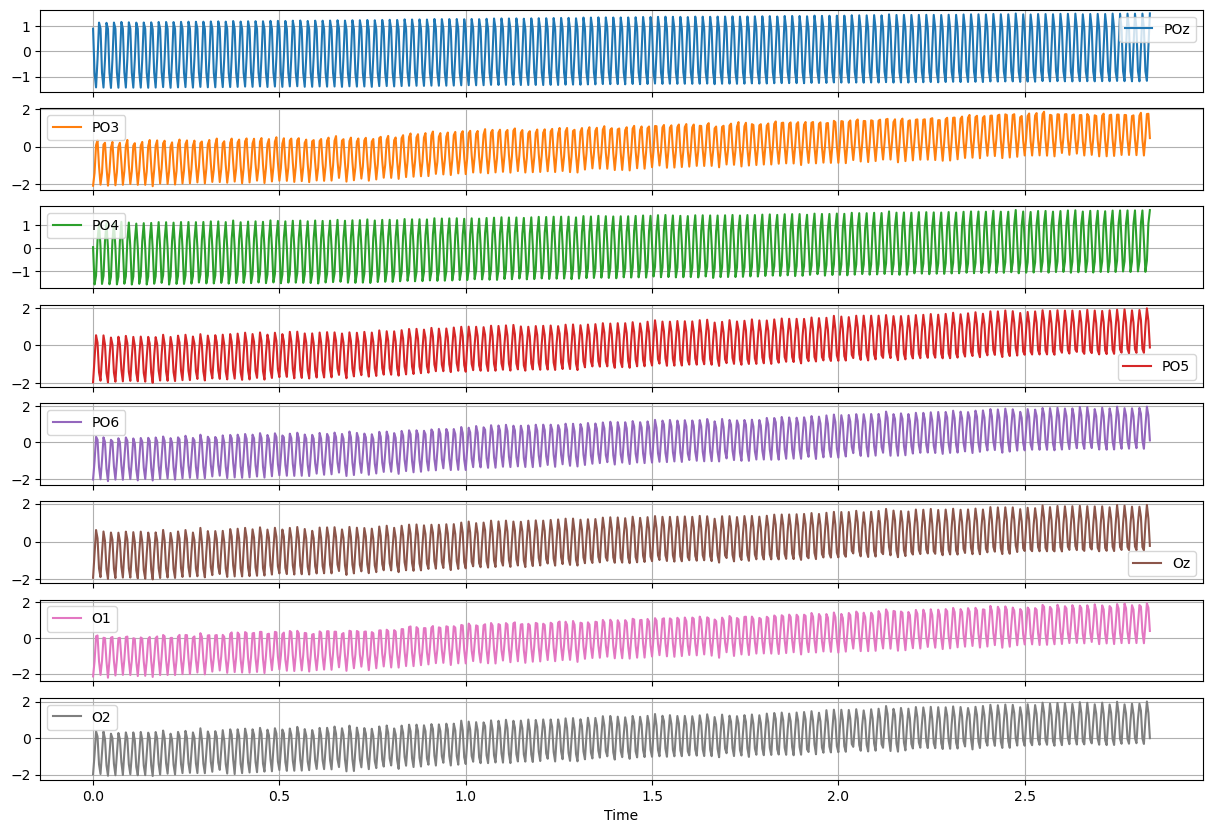

In [19]:
# plt.figure(figsize=(15,10))
ndf.plot(subplots=True,figsize=(15,10),grid=True)
plt.show()

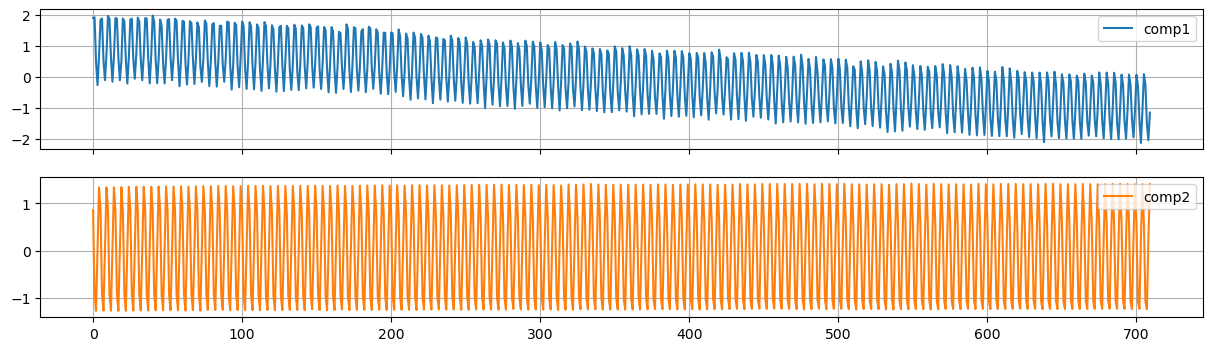

In [20]:
idf.plot(subplots=True,figsize=(15,4),grid=True)
plt.show()

In [21]:
def computeFFT(eeg_data, sampling_rate=250,absVal=True):
    # Length of the signal
    N = len(eeg_data)

    # Compute the FFT
    fft_result = np.fft.fft(eeg_data)

    # Compute the corresponding frequencies
    freqs = np.fft.fftfreq(N, 1/sampling_rate)

    # Get the magnitude of the FFT (only the positive half of the spectrum)
    if absVal:
        fft_magnitude = np.abs(fft_result)[:N//2]
    else:
        fft_magnitude = fft_result[:N//2]
    freqs = freqs[:N//2]
    return freqs, fft_magnitude

In [22]:
# count = 1
# plt.figure(figsize=(15,10))
# for ii in range(n_components):
#     plt.subplot(8,2,count)
#     count += 1
#     Freq,Mag = computeFFT(idf[idf.columns[ii]])
#     plt.plot(Freq,np.abs(Mag),label=idf.columns[ii])
#     plt.grid()
#     plt.legend()
#     plt.ylim(0,100)
#     plt.subplot(8,2,count)
#     count += 1
#     Freq,Mag = computeFFT(ndf[ndf.columns[ii]])
#     plt.plot(Freq,np.abs(Mag),label=ndf.columns[ii])
#     plt.grid()
#     plt.legend()
#     plt.ylim(0,100)
# plt.tight_layout()
# plt.subplots_adjust(hspace=0.5, wspace=0.1)
# plt.show()

In [23]:
fline = 50
sfreq = 250
out, _ = dss.dss_line(ndf.values, fline, sfreq, nkeep=1)

Reducing nfft to 710
[PCA] Explained variance of selected components : 81.41%
Power of components removed by DSS: 0.65


In [24]:
sdf = pd.DataFrame(out, columns=channelInd)
sdf.index = timeRange
sdf.head()

,POz,PO3,PO4,PO5,PO6,Oz,O1,O2
0.000,-0.608297,-0.859096,-0.833369,-0.493331,-0.641482,-0.419432,-0.886324,-0.572746
0.004,-0.937195,-1.340520,-1.623136,-0.613141,-0.960407,-0.573863,-1.248869,-0.835215
0.008,-0.440748,-0.735897,-0.626118,-0.432981,-0.600900,-0.380374,-0.747399,-0.563087
0.012,0.169428,-0.061816,0.614126,-0.344246,-0.307937,-0.321484,-0.282832,-0.380227
0.016,0.315185,-0.391283,0.614917,-0.642796,-0.595439,-0.615748,-0.617907,-0.677387


In [25]:
isComp = transformer.fit_transform(sdf.values)

In [26]:
scomp = ['scomp1','scomp2','scomp3','scomp4','scomp5','scomp6','scomp7','scomp8']
isdf = pd.DataFrame(isComp)
isdf.columns = scomp[:n_components]
isdf.head()

,scomp1,scomp2
0,-0.965886,-0.885588
1,-1.238829,-1.727571
2,-0.923539,-0.616893
3,-0.843945,0.848836
4,-1.514937,1.045064


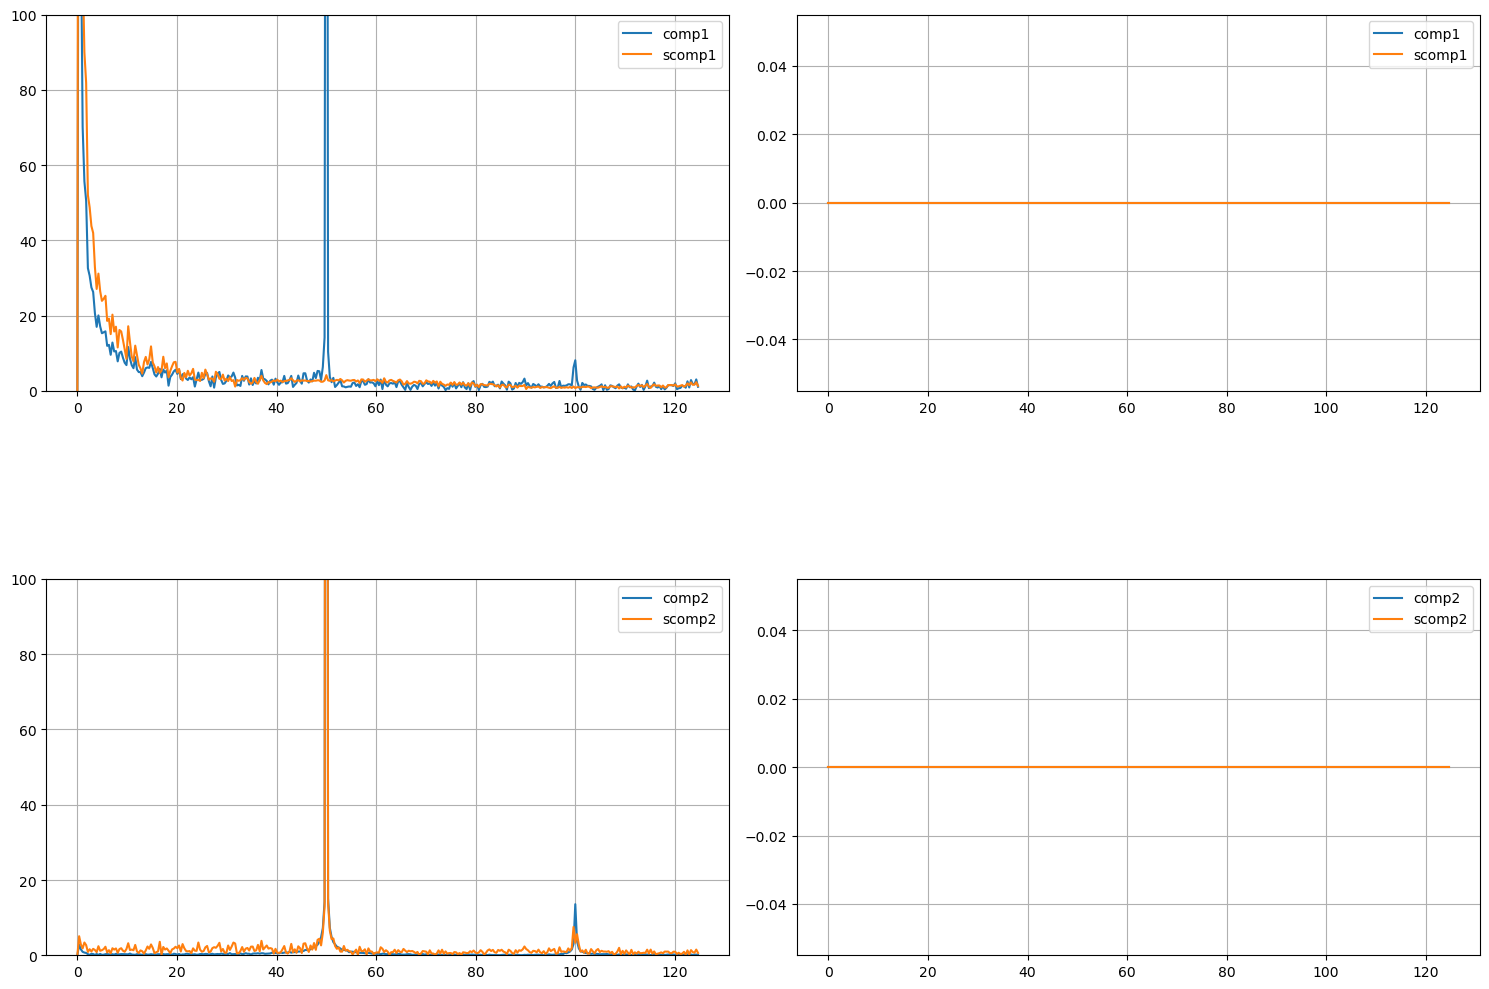

In [27]:
count = 1
plt.figure(figsize=(15,10))
for ii in range(n_components):
    plt.subplot(n_components,2,count)
    count += 1
    Freq,Mag = computeFFT(idf[idf.columns[ii]])
    Freqs,Mags = computeFFT(isdf[isdf.columns[ii]])
    plt.plot(Freq,np.abs(Mag),label=idf.columns[ii])
    plt.plot(Freqs,np.abs(Mags),label=isdf.columns[ii])
    plt.grid()
    plt.legend()
    plt.ylim(0,100)
    plt.subplot(n_components,2,count)
    count += 1
    plt.plot(Freq, np.angle(Mag),label=idf.columns[ii])
    plt.plot(Freqs, np.angle(Mags),label=isdf.columns[ii])
    plt.grid()
    plt.legend()
    # plt.ylim(0,200)
plt.tight_layout()
plt.subplots_adjust(hspace=0.5, wspace=0.1)
plt.show()

In [28]:
sampfreq = 250
channelInd

['POz', 'PO3', 'PO4', 'PO5', 'PO6', 'Oz', 'O1', 'O2']

In [29]:
info = mne.create_info(channelInd, ch_types="eeg", sfreq=sampfreq)
info.set_montage("standard_1020")

<Info | 8 non-empty values
 bads: []
 ch_names: POz, PO3, PO4, PO5, PO6, Oz, O1, O2
 chs: 8 EEG
 custom_ref_applied: False
 dig: 11 items (3 Cardinal, 8 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 8
 projs: []
 sfreq: 250.0 Hz
>

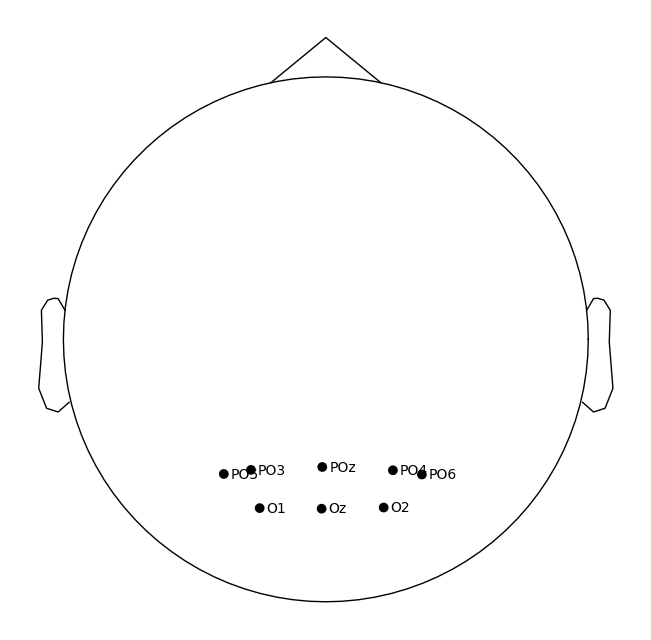

In [30]:
fig = info.plot_sensors(show_names=True,kind='topomap')

In [31]:
# mne.viz.plot_alignment(info,interaction = 'trackball')

In [60]:
raw = mne.io.RawArray(df.values.reshape(8,710),info)
raw.info["line_freq"] = 50.0
raw.filter(0.5, 120, n_jobs=1, fir_design='firwin')

Creating RawArray with float64 data, n_channels=8, n_times=710
    Range : 0 ... 709 =      0.000 ...     2.836 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 122.50 Hz)
- Filter length: 1651 samples (6.604 s)



<RawArray | 8 x 710 (2.8 s), ~59 kB, data loaded>

Effective window size : 2.840 (s)
Plotting power spectral density (dB=True).


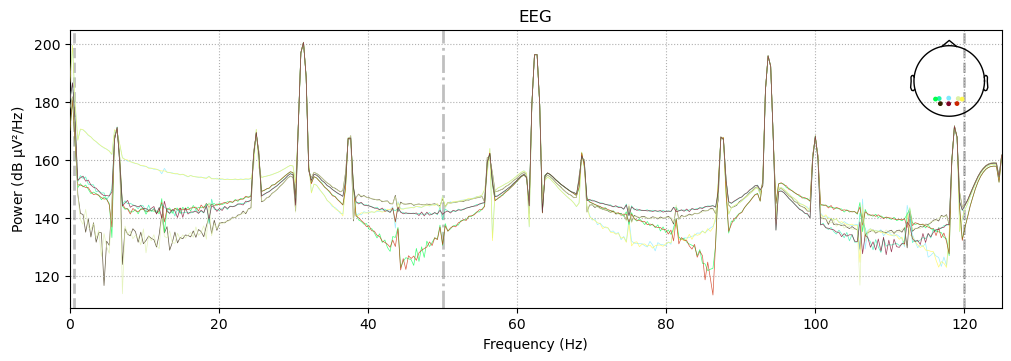

In [62]:
fig = raw.compute_psd().plot()

Effective window size : 2.840 (s)
Plotting power spectral density (dB=True).


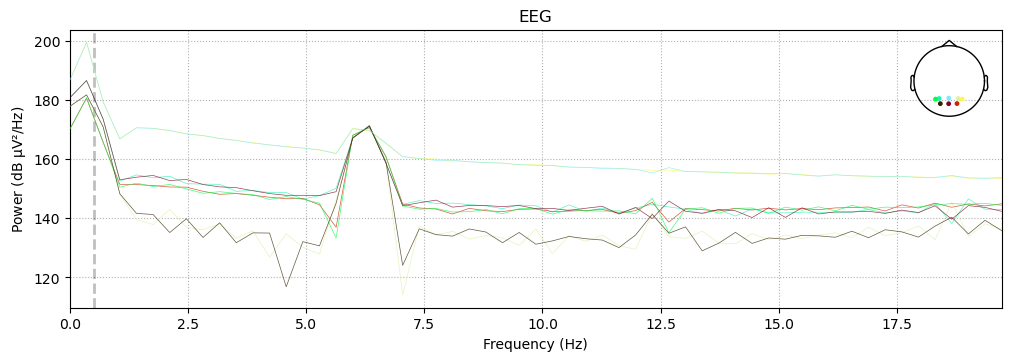

In [66]:
fig = raw.compute_psd(fmax=20).plot()

In [68]:
ica_obj = mne.preprocessing.ICA(
                    n_components=0.95,
                    method='infomax',
                    max_iter="auto",
                    random_state=1,
                    fit_params=dict(extended=True)).fit(raw)

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by explained variance: 4 components
Computing Extended Infomax ICA
Fitting ICA took 0.4s.


In [70]:
ica = ica_obj.get_sources(raw).get_data()

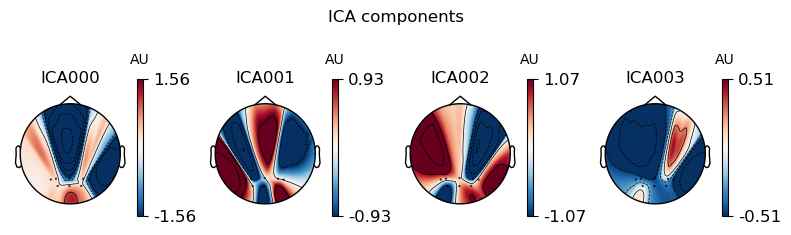

In [76]:
fig = ica_obj.plot_components(picks=None,show=True, inst=raw,colorbar =True)

In [78]:
raw_clean = ica_obj.apply(raw.copy())

Applying ICA to Raw instance
    Transforming to ICA space (4 components)
    Zeroing out 0 ICA components
    Projecting back using 8 PCA components


In [82]:
# raw_clean.plot()

In [86]:
fig = ica_obj.plot_sources(raw)

Creating RawArray with float64 data, n_channels=4, n_times=710
    Range : 0 ... 709 =      0.000 ...     2.836 secs
Ready.


In [89]:
def computeFFT(eeg_data, sampling_rate=250,absVal=True):
    # Length of the signal
    N = len(eeg_data)

    # Compute the FFT
    fft_result = np.fft.fft(eeg_data)

    # Compute the corresponding frequencies
    freqs = np.fft.fftfreq(N, 1/sampling_rate)

    # Get the magnitude of the FFT (only the positive half of the spectrum)
    if absVal:
        fft_magnitude = np.abs(fft_result)[:N//2]
    else:
        fft_magnitude = fft_result[:N//2]
    freqs = freqs[:N//2]
    return freqs, fft_magnitude

In [118]:
def FFTPlot(Freq, Mag,yMax=50):
    plt.figure(figsize=(10, 6))
    plt.plot(Freq, Mag, color='blue')
    plt.title('EEG Frequency Spectrum')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.grid(True)
    plt.ylim(0,yMax)
    plt.show()


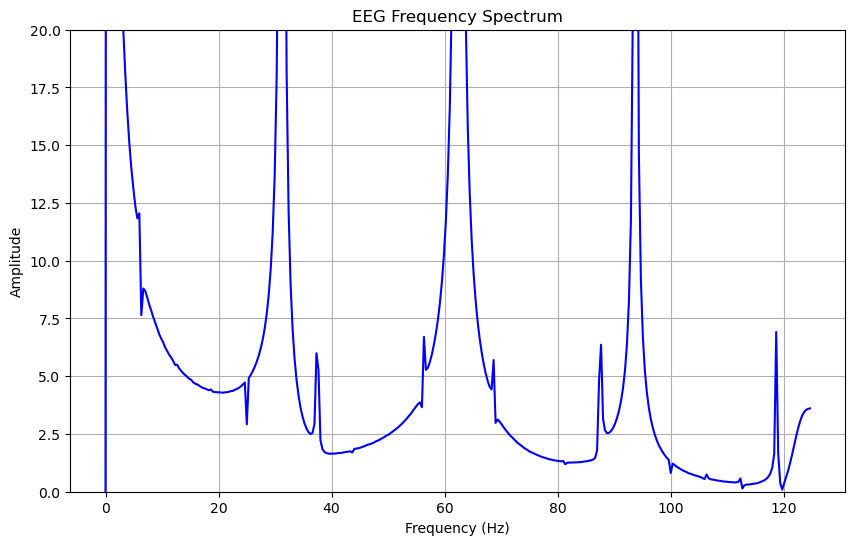

In [120]:
Freq,Mag = computeFFT(ica[0])
FFTPlot(Freq, Mag,20)

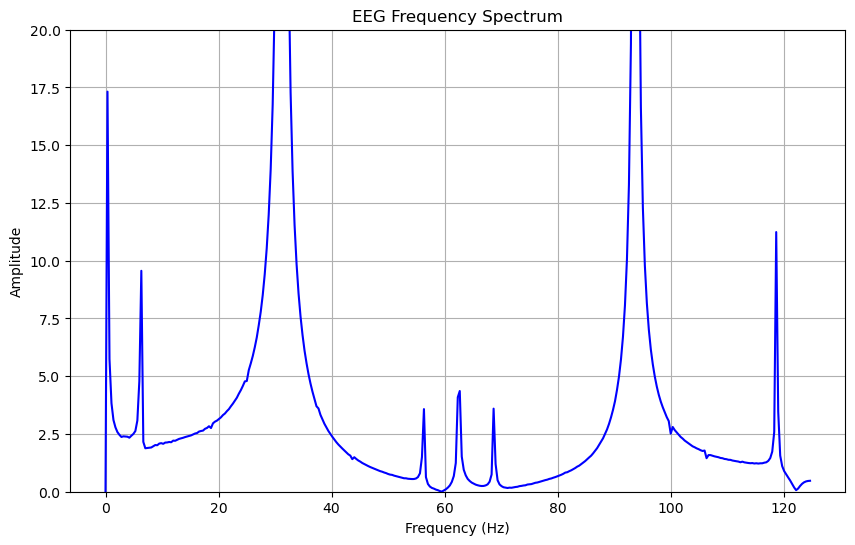

In [122]:
Freq,Mag = computeFFT(ica[1])
FFTPlot(Freq, Mag,20)

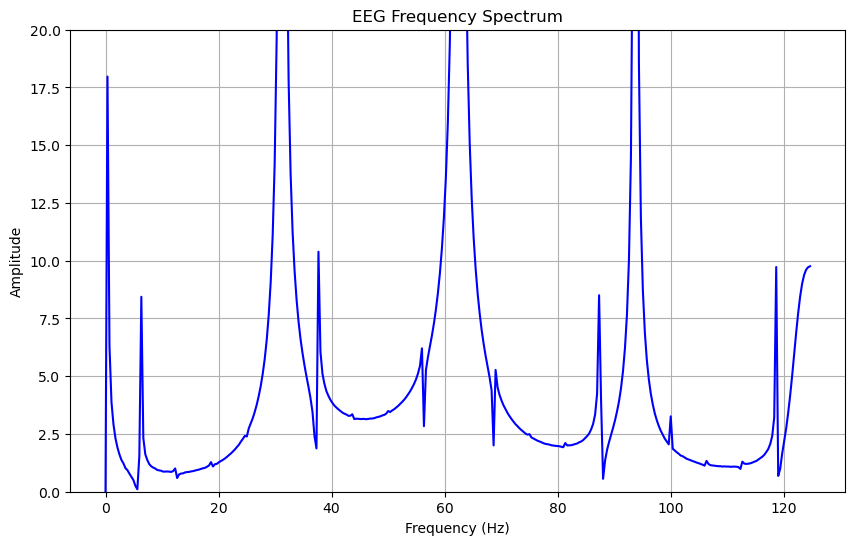

In [124]:
Freq,Mag = computeFFT(ica[2])
FFTPlot(Freq, Mag,20)

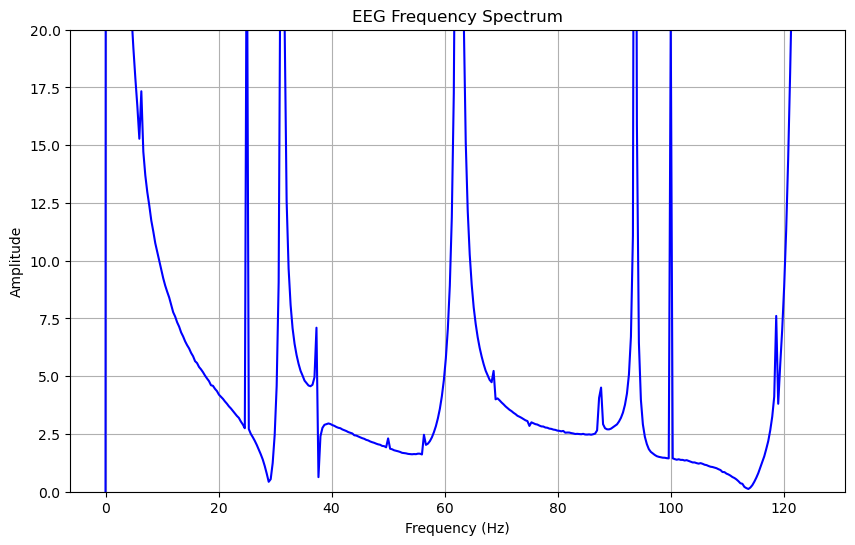

In [126]:
Freq,Mag = computeFFT(ica[3])
FFTPlot(Freq, Mag,20)